In [4]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data

def getCloseDataPandas(ticker, start, end=None):
    return data.get_data_yahoo(ticker, start, end)["Close"]


def getCloseDataFdr(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)["Close"]

def getCloseData(ticker, start, end=None):
    try:
        return getCloseDataFdr(ticker, start, end)
    except:
        getCloseDataPandas(ticker, start, end)
        

def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]

def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getPortfolioResult(closeDataSet, weight=None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    print(weight)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    
def getEval(cumRet):
    cagr = cumRet.iloc[-1] ** (252/len(cumRet))

    dd = (cumRet.cummax() - cumRet) / cumRet.cummax() * 100
    mdd = dd.max()
     
    print(f"return: {cumRet.iloc[-1]} \n cagr: {cagr} \n mdd: {mdd}")
    
    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data["year"] = data.index.year
    data["month"] = data.index.month

    #월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(["year", "month"], keep="last").index

    #분기말 리밸런싱 
    if period == "quarter":
        quarter = [3, 6, 9, 12]
        data = data.loc[data["month"].isin(quarter)]
        rebalancingDate = data.drop_duplicates(["year", "month"], keep="last").index

    #연말 리밸런싱
    if period == "year":
        rebalancingDate = data.drop_duplicates(["year"], keep="last").index

    return rebalancingDate    
 

def getRebalancingPortfolio(closeDataSet, period="month", weightDf=None, rebalDate=None):
    #자산별 비중, 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period)
           
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)],
                                index=rebalancingDate,
                                columns=closeDataSet.columns)

    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        if rebalDate is None:
            rebalancingDate = getRebalancingDate(closeDataSet, period=period)
        else:
            rebalancingDate = rebalDate

    portfolio = pd.DataFrame()

    totalAsset = 1
    start = rebalancingDate[0]
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end]
        cumRet = getCumulativeReturn(priceData)
        weightCumRet = weight * cumRet
        netCumRet = totalAsset * weightCumRet

        start = end
        totalAsset = netCumRet.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumRet])

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep="last")]
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1))

    return portfolioDayReturn, portfolioCumulativeReturn

    

In [18]:
# ============= 유대인 전략 ============= 

start, end = "2010-01-01", "2021-12-20"

spy = getCloseDataPandas("SPY", start, end)
tlt = getCloseDataPandas("TLT", start, end)
vnq = getCloseDataPandas("VNQ", start, end)
print(spy, tlt, vnq)

Date
2009-12-31    111.440002
2010-01-04    113.330002
2010-01-05    113.629997
2010-01-06    113.709999
2010-01-07    114.190002
                 ...    
2021-12-14    463.359985
2021-12-15    470.600006
2021-12-16    466.450012
2021-12-17    459.869995
2021-12-20    454.980011
Name: Close, Length: 3014, dtype: float64 Date
2009-12-31     89.889999
2010-01-04     89.809998
2010-01-05     90.389999
2010-01-06     89.180000
2010-01-07     89.330002
                 ...    
2021-12-14    150.699997
2021-12-15    149.250000
2021-12-16    149.139999
2021-12-17    150.830002
2021-12-20    149.699997
Name: Close, Length: 3014, dtype: float64 Date
2009-12-31     44.740002
2010-01-04     44.549999
2010-01-05     44.500000
2010-01-06     44.419998
2010-01-07     44.900002
                 ...    
2021-12-14    110.370003
2021-12-15    111.919998
2021-12-16    111.879997
2021-12-17    111.739998
2021-12-20    110.870003
Name: Close, Length: 3014, dtype: float64


In [19]:
closeData = pd.concat([spy, tlt, vnq], axis=1)
closeData.columns = ["SPY", "TLT", "VNQ"]
closeData

,SPY,TLT,VNQ
Date,,,
2009-12-31,111.440002,89.889999,44.740002
2010-01-04,113.330002,89.809998,44.549999
2010-01-05,113.629997,90.389999,44.500000
2010-01-06,113.709999,89.180000,44.419998
2010-01-07,114.190002,89.330002,44.900002
...,...,...,...
2021-12-14,463.359985,150.699997,110.370003
2021-12-15,470.600006,149.250000,111.919998
2021-12-16,466.450012,149.139999,111.879997


In [21]:
rebalDate = getRebalancingDate(closeData, "year")
portWeight = [0.333, 0.333, 0.333] #SPY, TLT, VNQ 
weightDf = pd.DataFrame([portWeight],
                                index=rebalDate,
                                columns=closeData.columns)
weightDf


,SPY,TLT,VNQ
Date,,,
2009-12-31,0.333,0.333,0.333
2010-12-31,0.333,0.333,0.333
2011-12-30,0.333,0.333,0.333
2012-12-31,0.333,0.333,0.333
2013-12-31,0.333,0.333,0.333
2014-12-31,0.333,0.333,0.333
2015-12-31,0.333,0.333,0.333
2016-12-30,0.333,0.333,0.333
2017-12-29,0.333,0.333,0.333


In [22]:
dayRet, cumRet = getRebalancingPortfolio(closeData, period="year", weightDf=weightDf, rebalDate=rebalDate)
print(dayRet, cumRet)

Date
2009-12-31         NaN
2010-01-04    1.003941
2010-01-05    1.002665
2010-01-06    0.995188
2010-01-07    1.005558
                ...   
2021-12-14    0.992134
2021-12-15    1.008134
2021-12-16    0.996517
2021-12-17    0.997569
2021-12-20    0.991294
Length: 3014, dtype: float64 Date
2009-12-31    0.999000
2010-01-04    1.002937
2010-01-05    1.005610
2010-01-06    1.000771
2010-01-07    1.006334
                ...   
2021-12-14    2.678359
2021-12-15    2.700144
2021-12-16    2.690740
2021-12-17    2.684200
2021-12-20    2.660832
Length: 3014, dtype: float64


return: 2.6608316965508956 
 cagr: 1.0852645800709002 
 mdd: 22.368357664198673
1.0852645800709002 22.368357664198673


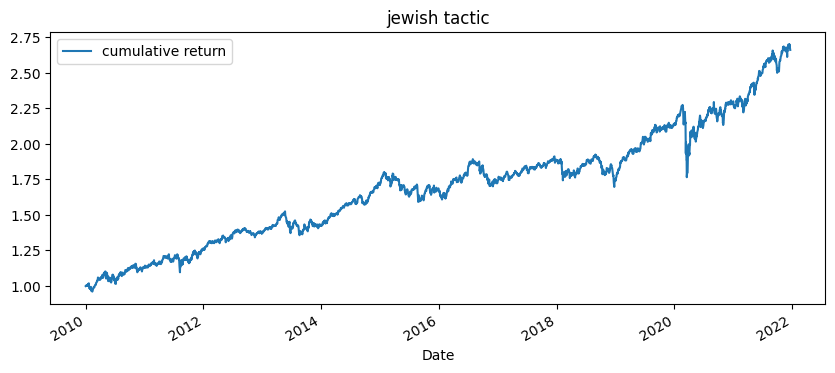

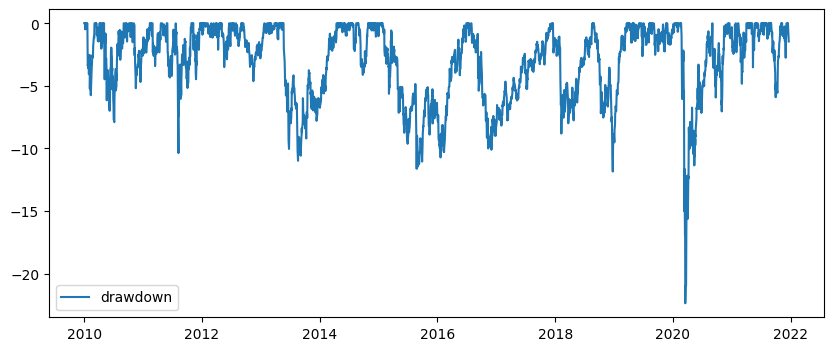

In [23]:
cagr, dd, mdd = getEval(cumRet)
print(cagr, mdd)


plt.subplots(figsize=(10, 4))
plt.title("jewish tactic")
cumRet.plot(label="cumulative return")
plt.legend()

plt.subplots(figsize=(10, 4))
plt.plot(-dd, label="drawdown")
plt.legend()

In [24]:
# ============= 60:40 전략 =============
start, end = "2010-01-01", "2021-12-20"

spy = getCloseDataPandas("SPY", start, end)
ief = getCloseDataPandas("IEF", start, end)
print(spy, ief)

Date
2009-12-31    111.440002
2010-01-04    113.330002
2010-01-05    113.629997
2010-01-06    113.709999
2010-01-07    114.190002
                 ...    
2021-12-14    463.359985
2021-12-15    470.600006
2021-12-16    466.450012
2021-12-17    459.869995
2021-12-20    454.980011
Name: Close, Length: 3014, dtype: float64 Date
2009-12-31     88.599998
2010-01-04     88.820000
2010-01-05     89.209999
2010-01-06     88.849998
2010-01-07     88.849998
                 ...    
2021-12-14    115.690002
2021-12-15    115.519997
2021-12-16    115.750000
2021-12-17    116.010002
2021-12-20    115.910004
Name: Close, Length: 3014, dtype: float64


In [25]:
closeData = pd.concat([spy, ief], axis=1)
closeData.columns = ["SPY", "IEF"]
closeData

,SPY,IEF
Date,,
2009-12-31,111.440002,88.599998
2010-01-04,113.330002,88.820000
2010-01-05,113.629997,89.209999
2010-01-06,113.709999,88.849998
2010-01-07,114.190002,88.849998
...,...,...
2021-12-14,463.359985,115.690002
2021-12-15,470.600006,115.519997
2021-12-16,466.450012,115.750000


In [26]:
rebalDate = getRebalancingDate(closeData, "year")
portWeight = [0.6, 0.4] #SPY , IEF 
weightDf = pd.DataFrame([portWeight],
                                index=rebalDate,
                                columns=closeData.columns)
weightDf

,SPY,IEF
Date,,
2009-12-31,0.6,0.4
2010-12-31,0.6,0.4
2011-12-30,0.6,0.4
2012-12-31,0.6,0.4
2013-12-31,0.6,0.4
2014-12-31,0.6,0.4
2015-12-31,0.6,0.4
2016-12-30,0.6,0.4
2017-12-29,0.6,0.4


In [27]:
dayRet, cumRet = getRebalancingPortfolio(closeData, period="year", weightDf=weightDf, rebalDate=rebalDate)
print(dayRet, cumRet)

Date
2009-12-31         NaN
2010-01-04    1.011169
2010-01-05    1.003339
2010-01-06    0.998823
2010-01-07    1.002550
                ...   
2021-12-14    0.994875
2021-12-15    1.009786
2021-12-16    0.994833
2021-12-17    0.991457
2021-12-20    0.992727
Length: 3014, dtype: float64 Date
2009-12-31    1.000000
2010-01-04    1.011169
2010-01-05    1.014545
2010-01-06    1.013350
2010-01-07    1.015935
                ...   
2021-12-14    2.708692
2021-12-15    2.735198
2021-12-16    2.721065
2021-12-17    2.697819
2021-12-20    2.678198
Length: 3014, dtype: float64


return: 2.6781978461140437 
 cagr: 1.0858550309546158 
 mdd: 18.165876532030477
1.0858550309546158 18.165876532030477


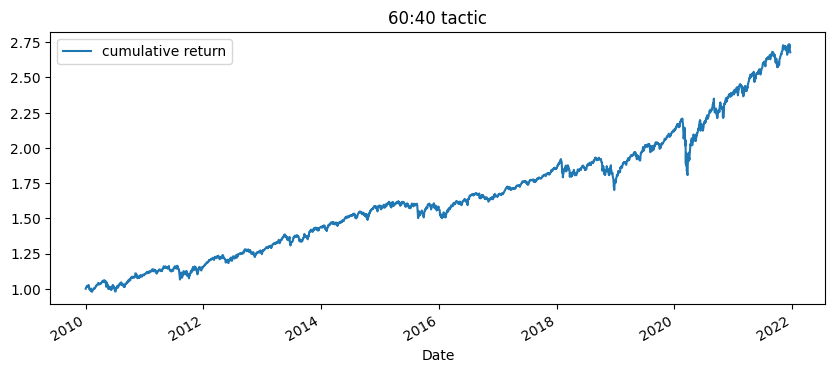

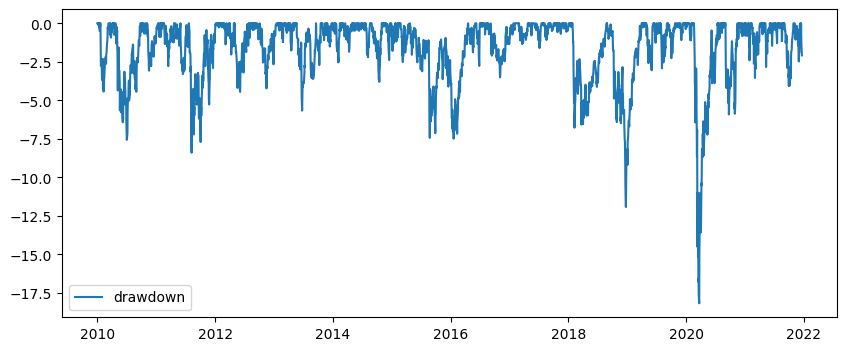

In [28]:
cagr, dd, mdd = getEval(cumRet)
print(cagr, mdd)


plt.subplots(figsize=(10, 4))
plt.title("60:40 tactic")
cumRet.plot(label="cumulative return")
plt.legend()

plt.subplots(figsize=(10, 4))
plt.plot(-dd, label="drawdown")
plt.legend()